In [1]:
import pandas as pd
import deepxde as dde
import numpy as np
import re
import matplotlib.pyplot as plt

Using backend: tensorflow.compat.v1



Instructions for updating:
non-resource variables are not supported in the long term


In [40]:
H = dde.Variable(1.6)
D = dde.Variable(0.0)

In [3]:
# '''
# 24th July, 2023 created by Likun Chen, Wuhan University
# This is for testing the PINN parameter estimation, object: syn-machine
# EXT Parameters:
#     Vi , initial terminal voltage : 1.0 pu
#     Ta , voltage regulator time constant : 0.4 sec
#     Kf , rate feedback gain : 0.03
# SYN Parameters:
#     H , inertia constant : 1.7 MWs/MVA
#     D , synchronous mechanical damping : 0.12 pu/pu
#     Xa , stator leakage reactance : 0.130 pu
#     Xd , d-axis unsaturated reactance : 1.79 pu
#     Xd' , d-axis unsaturated transient reactance : 0.169 pu
#     Xd'' , d-axis unsaturated Sub-Trans reactance : 0.135 pu
#     Xq , q-axis unsaturated reactance : 1.71 pu
#     Xq' , q-axis unsaturated transient reactance : 0.228 pu
#     Xq'' , q-axis unsaturated Sub-Trans reactance : 0.2 pu
# For 2-order equation, the state variables are rev (w) and phase angle (delta), 
# parameters waiting estimated are H , D , Eq' = Ed' = const
#     H * d2_delta/dt2 (This is dw/dt) + D * d_delta/dt + P_ex - P_mach = 0
#     P_ex is external power balance and P_mach is the mechanical power
#     time， P_ex, delta, P_mach, dw
# '''

In [4]:
input_data = pd.read_csv('data/920test1_te.csv', index_col=0)

In [5]:
input_data = input_data[1300:4000]

In [6]:
input_data.Time -= 0.00005 * 1300

In [7]:
input_data.set_index('Time', inplace=True)
input_data

,Pe,Tm,delta,Pt,w,Te
Time,,,,,,
0.00000,0.095500,0.000000,0.224092,0.330929,0.993108,1.021939
0.00005,0.095703,0.000000,0.224166,0.331355,0.993091,1.021959
0.00010,0.095906,0.000000,0.224255,0.331780,0.993074,1.021968
0.00015,0.096109,0.000000,0.224326,0.332203,0.993057,1.021987
0.00020,0.096311,0.000000,0.224418,0.332626,0.993040,1.022006
...,...,...,...,...,...,...
0.13475,0.396146,0.546094,0.407556,0.501721,0.951582,1.066728
0.13480,0.396198,0.546634,0.407612,0.501722,0.951573,1.066742
0.13485,0.396251,0.547174,0.407668,0.501723,0.951565,1.066748


In [8]:
input_data.drop(columns=['Pe','delta', 'Pt'], inplace=True)

In [9]:
input_data

,Tm,w,Te
Time,,,
0.00000,0.000000,0.993108,1.021939
0.00005,0.000000,0.993091,1.021959
0.00010,0.000000,0.993074,1.021968
0.00015,0.000000,0.993057,1.021987
0.00020,0.000000,0.993040,1.022006
...,...,...,...
0.13475,0.546094,0.951582,1.066728
0.13480,0.546634,0.951573,1.066742
0.13485,0.547174,0.951565,1.066748


<Axes: xlabel='Time'>

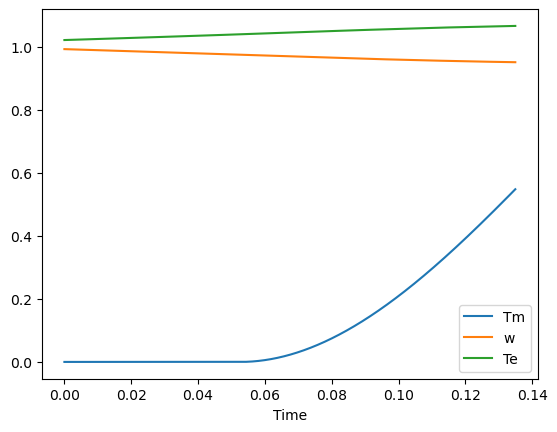

In [10]:
input_data.plot()

In [11]:
x = input_data.index.to_numpy()
x

array([0.0000e+00, 5.0000e-05, 1.0000e-04, ..., 1.3485e-01, 1.3490e-01,
       1.3495e-01])

In [12]:
geom = dde.geometry.TimeDomain(0, x[-1])

In [13]:
def boundary(_, on_initial):
    return on_initial

In [14]:
x0 = input_data.iloc[0].tolist()

In [15]:
# Initial conditions
ic1 = dde.icbc.IC(geom, lambda X: x0[0], boundary, component=0)
ic2 = dde.icbc.IC(geom, lambda X: x0[1], boundary, component=1)
ic3 = dde.icbc.IC(geom, lambda X: x0[2], boundary, component=2)

In [16]:
y = input_data.to_numpy()
y.shape

(2700, 3)

In [25]:
x

array([0.0000e+00, 5.0000e-05, 1.0000e-04, ..., 1.3485e-01, 1.3490e-01,
       1.3495e-01])

In [17]:
observe_t = x.reshape(-1, 1)

In [18]:
# Get the training data
observe_y0 = dde.icbc.PointSetBC(observe_t, y[:, 0:1], component=0)
observe_y1 = dde.icbc.PointSetBC(observe_t, y[:, 1:2], component=1)
observe_y2 = dde.icbc.PointSetBC(observe_t, y[:, 2:3], component=2)

In [36]:
# H * d2_delta/dt2 (This is dw/dt) + D * d_delta/dt + P_ex - P_mach = 0
def Microgrid_system(x, y):
    """Modified Lorenz system (with exogenous input).
    H * d2_delta/dt2 (This is dw/dt) + D * d_delta/dt + P_ex - P_mach = 0
    """
    time = x
    Tm, w, Te = y[:, 0:1], y[:, 1:2], y[:, 2:3]
    
    dw_dt = dde.grad.jacobian(y, x, i=1)
    return [
        Tm-Te - 2*H*dw_dt - D*(w-1)
    ]


In [37]:
# class ex_func2():
#     def __init__(self, input_data):
#         self.input_data = input_data
#     def fun(self, t):
#         t = t.reshape(-1, )
#         return self.input_data.iloc[t]['Subsystem #1|CTLs|Vars|PGEN'].to_numpy().reshape(-1, 1)

In [38]:
data = dde.data.PDE(
    geom,
    Microgrid_system,
    [ic1, ic2, ic3, observe_y0, observe_y1, observe_y2],
    # num_domain=400,
    # num_boundary=3,
    anchors=observe_t,
#     auxiliary_var_function=ex_func2(input_data).fun,
)

In [41]:
net = dde.nn.FNN([1] + [40] * 3 + [3], "tanh", "Glorot uniform")
model = dde.Model(data, net)
model.compile("adam", lr=0.001, external_trainable_variables=[H, D])



Compiling model...
Building feed-forward neural network...
'build' took 0.039235 s

'compile' took 0.256424 s



In [42]:
fnamevar = "variables_test1.dat"
variable = dde.callbacks.VariableValue([H, D], period=200, filename=fnamevar)
model.train(iterations=8000, callbacks=[variable])

Initializing variables...
Training model...

Step      Train loss                                                                Test loss                                                                 Test metric
0         [2.86e+00, 0.00e+00, 9.86e-01, 1.04e+00, 3.58e-02, 1.01e+00, 1.10e+00]    [2.86e+00, 0.00e+00, 9.86e-01, 1.04e+00, 3.58e-02, 1.01e+00, 1.10e+00]    []  
1000      [2.72e-03, 3.84e-05, 3.44e-06, 3.79e-04, 1.05e-02, 1.90e-06, 9.03e-04]    [2.72e-03, 3.84e-05, 3.44e-06, 3.79e-04, 1.05e-02, 1.90e-06, 9.03e-04]    []  
2000      [9.94e-06, 6.19e-04, 1.28e-06, 5.07e-07, 8.92e-03, 3.04e-06, 9.37e-07]    [9.94e-06, 6.19e-04, 1.28e-06, 5.07e-07, 8.92e-03, 3.04e-06, 9.37e-07]    []  
3000      [9.64e-06, 6.20e-04, 1.29e-06, 3.43e-07, 8.87e-03, 2.87e-06, 5.58e-07]    [9.64e-06, 6.20e-04, 1.29e-06, 3.43e-07, 8.87e-03, 2.87e-06, 5.58e-07]    []  
4000      [7.20e-06, 6.29e-04, 1.11e-06, 2.45e-07, 8.81e-03, 2.75e-06, 5.25e-07]    [7.20e-06, 6.29e-04, 1.11e-06, 2.45e-07, 8.81e-03

(<deepxde.model.LossHistory at 0x2170816b520>,
 <deepxde.model.TrainState at 0x21708aa2580>)

In [43]:
lines = open(fnamevar, "r").readlines()
# read output data in fnamevar (this line is a long story...)
Chat = np.array(
    [
        np.fromstring(
            min(re.findall(re.escape("[") + "(.*?)" + re.escape("]"), line), key=len),
            sep=",",
        )
        for line in lines
    ]
)

Text(0.5, 0, 'Epoch')

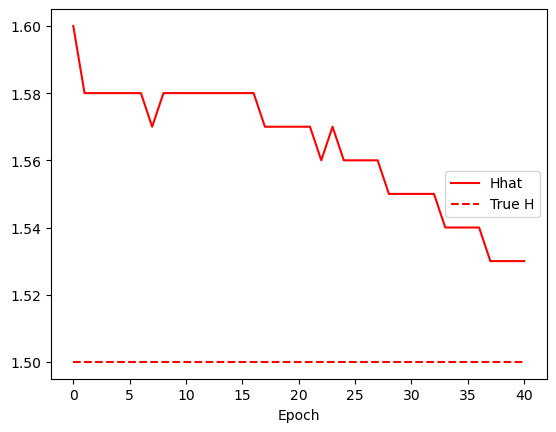

In [44]:
l, c = Chat.shape
plt.plot(range(l), Chat[:, 0], "r-")

plt.plot(range(l), np.ones(Chat[:, 0].shape) * 1.5, "r--")

plt.legend(["Hhat","True H"], loc="right")
plt.xlabel("Epoch")

Text(0.5, 0, 'Epoch')

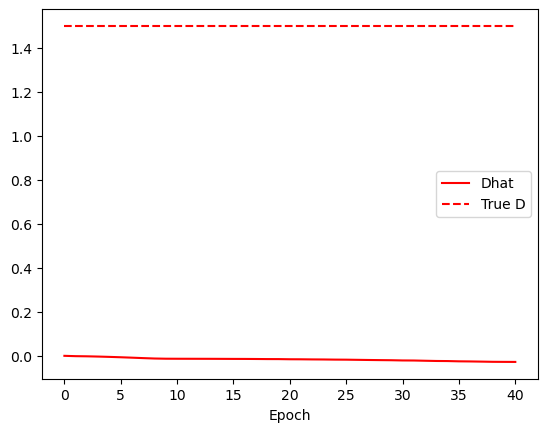

In [45]:
l, c = Chat.shape
plt.plot(range(l), Chat[:, 1], "r-")

plt.plot(range(l), np.ones(Chat[:, 1].shape) * 1.5, "r--")

plt.legend(["Dhat","True D"], loc="right")
plt.xlabel("Epoch")

In [ ]:
pd.Series((input_data.Tm - input_data.Te).to_numpy()[1:] / ((input_data.w.to_numpy()[1:] - input_data.w.to_numpy()[:-1]) / (input_data.index[1] - input_data.index[0])) / 2).plot()

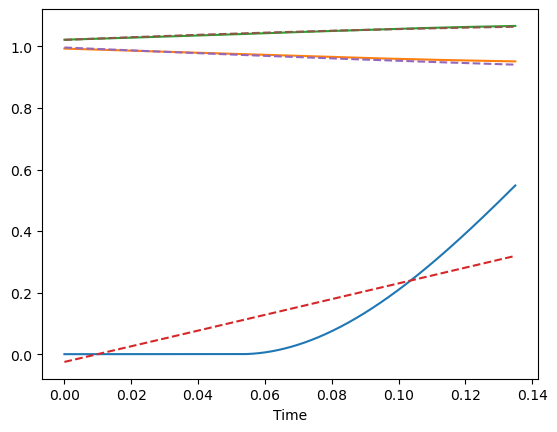

In [42]:
yhat = model.predict(observe_t)
plt.figure()
plt.plot(observe_t, y, "-", observe_t, yhat, "--")
plt.xlabel("Time")
# plt.legend(["x", "y", "z", "xh", "yh", "zh"])
# plt.title("Training data")
plt.show()